In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import boto3
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import fun_eda, fun_s3, fun_read_parquet

In [3]:
# Load all the data from dataforgood
#original_data = fun_read_parquet.get_dataforgood_data()
bucket_name = 'movicovid'
fname = '{}/{}/{}'.format('data', 'dataforgood', 'movimientos_entre_administraciones_08062020.csv')
original_data = fun_s3.abre_file_como_df(bucket_name, fname)

In [4]:
####################################   CAMBIO TIPO DE VARIABLES
original_data['starting_region_name'] = original_data['starting_region_name'].astype('category')
original_data['ending_region_name'] = original_data['ending_region_name'].astype('category')
original_data['fecha'] = pd.to_datetime(original_data['fecha'])
original_data['hr'] = original_data['hora'].str.slice(start=0, stop=2).astype(int)

####################################   SELECCIONAMOS VARIABLES DE INTERES
data = original_data[['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name', 'percent_change',
                     'ending_region_name', 'length_km', 'hr','fecha']].copy()

####################################  DROP REGISTROS DUPLICADOS
# elimina todos, menos el primero
data.drop_duplicates(subset = ['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name',
                               'percent_change', 'ending_region_name', 'length_km', 'hr','fecha'], 
                              keep = 'first', inplace = True) 
## *Duplicados: 5,433

In [5]:
delegaciones = ["Álvaro Obregón", "Azcapotzalco", "Benito Juárez", "Coyoacán", "Cuajimalpa de Morelos", "Cuauhtémoc",
                "Gustavo A. Madero", "Iztacalco", "Iztapalapa", "La Magdalena Contreras", "Miguel Hidalgo", "Milpa Alta",
                "Tláhuac", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

alc_mun = pd.Series(data['starting_region_name'].unique()).append(pd.Series(data['ending_region_name'].unique())).unique()

municipios = alc_mun[~alc_mun.isin(delegaciones)]

In [6]:
####################################   TRANSFORMACION DE VARIABLES  ####################################

#### Añado columnas que indican si el Origen/Destino es en CDMX
data = data.assign(ori_cdmx=np.where(data["starting_region_name"].isin(delegaciones), 'CDMX', 'Otro'), 
                   des_cdmx=np.where(data["ending_region_name"].isin(delegaciones), 'CDMX', 'Otro'))

### Añado una columna que contabilice el numero de semanas
data['num_semana'] = data['fecha'].dt.week

### Añado una columna para el dia de la semana
dict_days = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
data['dia_semana'] = data['fecha'].dt.dayofweek.map(dict_days)

### Anado una columna para identificar la ruta
data['ruta'] = data['starting_region_name'].astype(str) + " - " + data['ending_region_name'].astype(str)

# Comparacion de Baseline

Comparamos el baseline de la base original contra el movimiento del 29 de febrero al 6 de marzo.


In [7]:
# Fechas de la base
print("Fecha de inicio de la base: ", data['fecha'].min())
print("Fecha final de la base: ", data['fecha'].max())

Fecha de inicio de la base:  2020-02-27 00:00:00
Fecha final de la base:  2020-06-07 00:00:00


In [8]:
print(data.shape)
data.head(2)

(279062, 14)


difference  baseline_people_moving  crisis_people_moving  \
0         3.6                    61.4                    65   
1      -161.2                 29851.2                 29690   

  starting_region_name  percent_change ending_region_name  length_km  hr  \
0         Azcapotzalco        5.769231            Acolman  25.572917   0   
1        Benito Juárez       -0.539994      Benito Juárez   0.086858   0   

       fecha ori_cdmx des_cdmx  num_semana dia_semana  \
0 2020-02-27     CDMX     Otro           9     Jueves   
1 2020-02-27     CDMX     CDMX           9     Jueves   

                            ruta  
0         Azcapotzalco - Acolman  
1  Benito Juárez - Benito Juárez

In [9]:
baseline_stats_all = data[['ruta', 'dia_semana', 'hr', 'baseline_people_moving']].groupby(['ruta', 'dia_semana', 'hr']).agg({'baseline_people_moving':['max', 'min', 'mean', 'std', 'count', 'nunique']}).reset_index().round(2)
#baseline_stats_all.columns = ["_".join(x) for x in baseline_stats_all.columns.ravel()]
#baseline_stats_all = baseline_stats_all.style.format({'Dollar Amount': "{:,}"})
#baseline_stats_all

#### En 35 casos, se tienen mas de 1 baseline
#baseline_stats_all[baseline_stats_all[('baseline_people_moving', 'nunique')]>1]


### New baseline

In [10]:
# Dias de interes: del 29 de Febrero al 6 de Marzo 
new_baseline = data.loc[(data['fecha']>='2020-02-29')  & (data['fecha']<'2020-03-06')].copy()

print("\t\t\t\tNew baseline")
new_baseline_stats = new_baseline[['ruta', 'dia_semana', 'hr', 'crisis_people_moving']].groupby(['ruta', 'dia_semana', 'hr']).agg({'crisis_people_moving':['max', 'min', 'mean', 'nunique']}).reset_index().round(2)
new_baseline_stats

				New baseline


ruta dia_semana  hr crisis_people_moving  \
                                                                       max   
0                    Acolman - Acolman    Domingo   0                 8182   
1                    Acolman - Acolman     Jueves   0                 7729   
2                    Acolman - Acolman     Jueves   8                 8497   
3                    Acolman - Acolman     Jueves  16                 7100   
4                    Acolman - Acolman     Martes   8                 8627   
...                                ...        ...  ..                  ...   
15979  Álvaro Obregón - Álvaro Obregón  Miércoles   8                75858   
15980  Álvaro Obregón - Álvaro Obregón  Miércoles  16                73207   
15981  Álvaro Obregón - Álvaro Obregón     Sábado   0                65751   
15982  Álvaro Obregón - Álvaro Obregón     Sábado   8                72964   
15983  Álvaro Obregón - Álvaro Obregón     Sábado  16                67015   

                             
         min   mean nunique  
0       8182   8182       1  
1       7729   7729       1  
2       8497   8497       1  
3       7100   7100       1  
4       8627   8627       1  
...      ...    ...     ...  
15979  75858  75858       1  
15980  73207  73207       1  
15981  65751  65751       1  
15982  72964  72964       1  
15983  67015  67015       1  

[15984 rows x 7 columns]

In [11]:
# Obtengo rutas
rutas = new_baseline.ruta.unique()
print("Numero de rutas en total (base): ", data.ruta.unique().shape[0])
print("Numero de rutas de Feb 29 al 6 de Marzo: ", rutas.shape[0])
print("Diferencia: ", data.ruta[~data.ruta.isin(set(rutas))].unique().shape[0])

Numero de rutas en total (base):  1571
Numero de rutas de Feb 29 al 6 de Marzo:  1466
Diferencia:  105


In [12]:
#data.ruta[~data.ruta.isin(set(rutas))].unique()
# 'Tlalnepantla de Baz - Chalco' existe solo para '2020-02-27' y '2020-03-19'

In [13]:
data_cropped = data[data.ruta.isin(rutas)].copy()
baseline_stats = data_cropped[['ruta', 'dia_semana', 'hr', 'baseline_people_moving']].groupby(['ruta', 'dia_semana', 'hr']).agg({'baseline_people_moving':['max', 'min', 'mean', 'std', 'count', 'nunique']}).reset_index().round(2)
print("\t\t\t\tBaseline Original")
baseline_stats

				Baseline Original


ruta dia_semana  hr baseline_people_moving  \
                                                                         max   
0                    Acolman - Acolman    Domingo   0                8336.40   
1                    Acolman - Acolman    Domingo   8                9097.00   
2                    Acolman - Acolman    Domingo  16                8277.80   
3                    Acolman - Acolman     Jueves   0                7879.00   
4                    Acolman - Acolman     Jueves   8                8481.00   
...                                ...        ...  ..                    ...   
23713  Álvaro Obregón - Álvaro Obregón     Sábado   8               73709.25   
23714  Álvaro Obregón - Álvaro Obregón     Sábado  16               67477.00   
23715  Álvaro Obregón - Álvaro Obregón    Viernes   0               70373.60   
23716  Álvaro Obregón - Álvaro Obregón    Viernes   8               75160.20   
23717  Álvaro Obregón - Álvaro Obregón    Viernes  16               72110.80   

                                              
            min      mean  std count nunique  
0       8336.40   8336.40  0.0    15       1  
1       9097.00   9097.00  0.0    14       1  
2       8277.80   8277.80  0.0    14       1  
3       7879.00   7879.00  0.0    15       1  
4       8481.00   8481.00  0.0    15       1  
...         ...       ...  ...   ...     ...  
23713  73709.25  73709.25  0.0    15       1  
23714  67477.00  67477.00  0.0    15       1  
23715  70373.60  70373.60  0.0    15       1  
23716  75160.20  75160.20  0.0    15       1  
23717  72110.80  72110.80  0.0    15       1  

[23718 rows x 9 columns]

In [14]:
#### En 35, se tienen mas de 1 baseline
# esto representa 17 rutas
baseline_repeated = baseline_stats[baseline_stats[('baseline_people_moving', 'nunique')]>1]
#baseline_repeated


In [15]:
id_repeated = baseline_repeated['ruta'] + " - " + baseline_repeated['dia_semana'] + " - " + baseline_repeated['hr'].astype(str)
#id_repeated

Quito las rutas con baseline repetidos.
(Las examinare en una seccion aparte)

In [16]:
new_baseline['id'] =  new_baseline['ruta'] + " - " + new_baseline['dia_semana'] + " - " + new_baseline['hr'].astype(str)
data_cropped['id'] =  data_cropped['ruta'] + " - " + data_cropped['dia_semana'] + " - " + data_cropped['hr'].astype(str)

new_baseline_unique = new_baseline.loc[~new_baseline.id.isin(id_repeated), ['id', 'crisis_people_moving', 'ruta', 'dia_semana', 'hr']]
baseline_unique = data_cropped.loc[(~data_cropped.id.isin(id_repeated)) & (data_cropped.id.isin(new_baseline.id)), ['id', 'baseline_people_moving', 'ruta', 'dia_semana', 'hr']].groupby(['id', 'ruta', 'dia_semana', 'hr']).mean().reset_index()

print(new_baseline_unique.shape, baseline_unique.shape)

(15951, 5) (15951, 5)


### Diferencias absolutas

In [17]:
diff = new_baseline_unique.merge(baseline_unique[['id', 'baseline_people_moving']], on=['id'], how='left')
diff['diferencia'] = diff['crisis_people_moving']-diff['baseline_people_moving']
diff = diff[['id', 'diferencia', 'crisis_people_moving', 'baseline_people_moving', 'ruta', 'dia_semana', 'hr']]

In [18]:
print("Registros sin diferencias: ", diff.diferencia[diff.diferencia==0].shape[0])
print("Registros con diferencias: ", diff.diferencia[diff.diferencia!=100].shape[0])
print("Maxima diferencia en: ", diff.loc[diff.diferencia.idxmax(),['id', 'baseline_people_moving', 'crisis_people_moving']])
fun_eda.descriptive_stats_for_numeric_vars(diff, ['diferencia']).round(2).transpose()

Registros sin diferencias:  76
Registros con diferencias:  15951
Maxima diferencia en:  id                        Cuauhtémoc - Cuauhtémoc - Sábado - 16
baseline_people_moving                                   200588
crisis_people_moving                                     210991
Name: 3234, dtype: object


n_observations       max     min   mean  std_dev   25%  median  \
diferencia         15951.0  10402.75 -4998.2  21.83   236.02 -6.25     3.8   

             75%  kurtosis  skewness  n_unique_values  %_missings  \
diferencia  20.4    495.89     13.38           5845.0         0.0   

            Top1_most_common  Top2_most_common  Top3_most_common  
diferencia               1.0               3.0               2.0

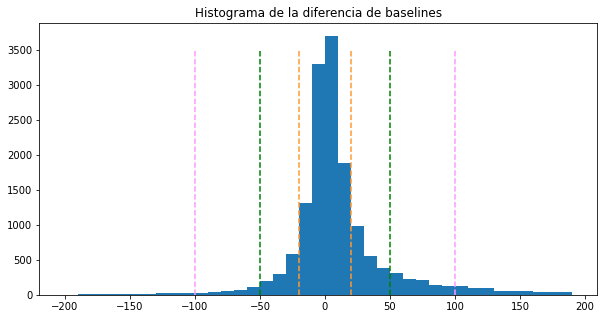

In [19]:
plt.figure(figsize=(10,5))
bins=range(-200,200,10)
plt.hist(diff['diferencia'], bins=bins, density=False)
plt.title("Histograma de la diferencia de baselines")
plt.vlines(x=20, ymin=0, ymax= 3500, linestyles ="dashed", colors ="#ff9933")
plt.vlines(x=-20, ymin=0, ymax= 3500, linestyles ="dashed", colors ="#ff9933")
plt.vlines(x=50, ymin=0, ymax= 3500, linestyles ="dashed", colors ="green")
plt.vlines(x=-50, ymin=0, ymax= 3500, linestyles ="dashed", colors ="green")
plt.vlines(x=100, ymin=0, ymax= 3500, linestyles ="dashed", colors ="#ff99ff")
plt.vlines(x=-100, ymin=0, ymax= 3500, linestyles ="dashed", colors ="#ff99ff")
plt.show()

In [20]:
bins = [0,20,50,100,100000]
labels = ["(-20,20)", "(-50, -20] o [20, 50)", "(-100, -50] o [50, 100)", ">-100 o 100<"]
grupos = pd.cut(abs(diff.diferencia), bins, labels=labels, right = False)

index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = diff.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = diff.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = diff.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = diff.loc[index_grupo4]



In [21]:
n = diff.diferencia.shape[0]
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[0], grupo1.shape[0], round((grupo1.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[1], grupo2.shape[0], round((grupo2.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[2], grupo3.shape[0], round((grupo3.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[3], grupo4.shape[0], round((grupo4.shape[0]/n)*100,2)))

Numero de rutas con una diferencia entre (-20,20): 10172 (63.77%)
Numero de rutas con una diferencia entre (-50, -20] o [20, 50): 3017 (18.91%)
Numero de rutas con una diferencia entre (-100, -50] o [50, 100): 1311 (8.22%)
Numero de rutas con una diferencia entre >-100 o 100<: 1451 (9.1%)


### Diferencias relativas

Tomando como base el baseline original (fb): $ \displaystyle  \frac{\text{crisis people moving} - \text{baseline people moving}}{\text{baseline people moving}}$

In [22]:
diff['dif_relativa'] = ((diff['crisis_people_moving']-diff['baseline_people_moving'])/diff['baseline_people_moving'])*100
diff = diff[['id', 'dif_relativa', 'diferencia', 'crisis_people_moving', 'baseline_people_moving', 'ruta', 'dia_semana', 'hr']]

In [23]:
print("Registros sin diferencias %: ", diff.dif_relativa[diff.dif_relativa==0].shape[0])
print("Registros con diferencias %: ", diff.dif_relativa[diff.dif_relativa!=0].shape[0])
print("Maxima diferencia en: ", diff.loc[diff.dif_relativa.idxmax(),['id', 'baseline_people_moving', 'crisis_people_moving']])
fun_eda.descriptive_stats_for_numeric_vars(diff, ['dif_relativa']).round(2).transpose()

Registros sin diferencias %:  76
Registros con diferencias %:  15875
Maxima diferencia en:  id                        Cuautitlán Izcalli - Iztacalco - Lunes - 0
baseline_people_moving                                            20
crisis_people_moving                                             296
Name: 14198, dtype: object


n_observations     max    min  mean  std_dev   25%  median  \
dif_relativa         15951.0  1380.0 -74.25  7.07    39.15 -4.24    2.15   

                75%  kurtosis  skewness  n_unique_values  %_missings  \
dif_relativa  11.77    311.09     13.22          13505.0         0.0   

              Top1_most_common  Top2_most_common  Top3_most_common  
dif_relativa               0.0             14.29            -16.67

In [44]:
data[(data.ruta=='Cuautitlán Izcalli - Iztacalco') & (data.dia_semana=='Lunes') & (data.hr==0)]

difference  baseline_people_moving  crisis_people_moving  \
30099         -2.0                    20.0                    18   
52903        213.0                    20.0                   233   
94415         -5.0                    20.0                    15   
134169       276.0                    20.0                   296   

       starting_region_name  percent_change ending_region_name  length_km  hr  \
30099    Cuautitlán Izcalli       -9.523810          Iztacalco  31.785615   0   
52903    Cuautitlán Izcalli     1014.285714          Iztacalco  30.191773   0   
94415    Cuautitlán Izcalli      -23.809524          Iztacalco  28.941488   0   
134169   Cuautitlán Izcalli     1314.285714          Iztacalco  30.206224   0   

            fecha ori_cdmx des_cdmx  num_semana dia_semana  \
30099  2020-03-09     Otro     CDMX          11      Lunes   
52903  2020-03-16     Otro     CDMX          12      Lunes   
94415  2020-03-30     Otro     CDMX          14      Lunes   
134169 2020-03-02     Otro     CDMX          10      Lunes   

                                  ruta  
30099   Cuautitlán Izcalli - Iztacalco  
52903   Cuautitlán Izcalli - Iztacalco  
94415   Cuautitlán Izcalli - Iztacalco  
134169  Cuautitlán Izcalli - Iztacalco

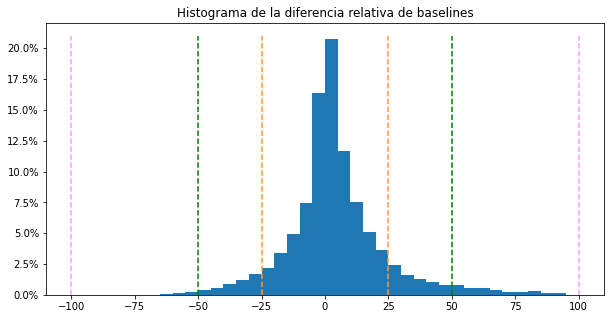

In [24]:
plt.figure(figsize=(10,5))
bins=range(-100,100,5)
plt.hist(diff.dif_relativa, bins=bins, density=False, weights=np.ones(len(diff.dif_relativa)) / len(diff.dif_relativa))
plt.title("Histograma de la diferencia relativa de baselines")
plt.vlines(x=25, ymin=0, ymax= .21, linestyles ="dashed", colors ="#ff9933")
plt.vlines(x=-25, ymin=0, ymax= .21, linestyles ="dashed", colors ="#ff9933")
plt.vlines(x=50, ymin=0, ymax= .21, linestyles ="dashed", colors ="green")
plt.vlines(x=-50, ymin=0, ymax= .21, linestyles ="dashed", colors ="green")
plt.vlines(x=100, ymin=0, ymax= .21, linestyles ="dashed", colors ="#ff99ff")
plt.vlines(x=-100, ymin=0, ymax= .21, linestyles ="dashed", colors ="#ff99ff")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [25]:
bins = [0,25,50,100,200000]
labels = ["[-25%, 25%)", "(-50%, -25%] o [25%, 50%)", "(-100%, 50] o [50%, 100%)", "<-100% o 100%<"]
grupos = pd.cut(abs(diff.dif_relativa), bins=bins, labels=labels, right = False)

index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = diff.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = diff.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = diff.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = diff.loc[index_grupo4]

In [26]:
n= diff.dif_relativa.shape[0]
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[0], grupo1.shape[0], round((grupo1.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[1], grupo2.shape[0], round((grupo2.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[2], grupo3.shape[0], round((grupo3.shape[0]/n)*100,2)))
print('Numero de rutas con una diferencia entre {}: {} ({}%)'.format(grupos.cat.categories[3], grupo4.shape[0], round((grupo4.shape[0]/n)*100,2)))

Numero de rutas con una diferencia entre [-25%, 25%): 13241 (83.01%)
Numero de rutas con una diferencia entre (-50%, -25%] o [25%, 50%): 1890 (11.85%)
Numero de rutas con una diferencia entre (-100%, 50] o [50%, 100%): 616 (3.86%)
Numero de rutas con una diferencia entre <-100% o 100%<: 204 (1.28%)


In [27]:
def grafica_diff(grupo, categoria):
    
     fig = px.scatter(x=grupo.id, y=grupo.dif_relativa)
                     
     fig.update_layout(   
        title="Diferencia relativa entre el baseline original y el nuevo <br> (Diferencia entre {})".format(categoria),
        yaxis_title="Diferencia relativa",
        xaxis_title="",
        #Format for title, & axis labels
        font=dict(
            #family="Courier New, monospace",
            size=12,
            color="Black"),
        showlegend=False,
        autosize=False,
        width=1000,
        height=500,
     )    
        
     fig.show()

In [28]:
grafica_diff(grupo4, grupos.cat.categories[3] )
grafica_diff(grupo3, grupos.cat.categories[2] )
grafica_diff(grupo2, grupos.cat.categories[1] )
grafica_diff(grupo1, grupos.cat.categories[0] )

### Rutas con baseline original repetido

In [40]:
baseline_repeated = data_cropped.loc[data_cropped.id.isin(id_repeated), ['id', 'baseline_people_moving', 'crisis_people_moving', 'ruta', 'dia_semana', 'hr', 'fecha']].copy()
baseline_repeated.drop_duplicates(subset = ['id', 'baseline_people_moving'], keep = 'first', inplace = True)
print(baseline_repeated.shape)
baseline_repeated.sort_values(['id']).head(5)

(70, 7)


id  \
10378   Atizapán de Zaragoza - Iztapalapa - Domingo - 0   
131691  Atizapán de Zaragoza - Iztapalapa - Domingo - 0   
27897   Atizapán de Zaragoza - Iztapalapa - Domingo - 8   
131692  Atizapán de Zaragoza - Iztapalapa - Domingo - 8   
30117     Atizapán de Zaragoza - Iztapalapa - Lunes - 0   

        baseline_people_moving  crisis_people_moving  \
10378                     14.4                    15   
131691                  5975.2                  2870   
27897                     13.4                    15   
131692                  2779.2                  1282   
30117                     23.0                    20   

                                     ruta dia_semana  hr      fecha  
10378   Atizapán de Zaragoza - Iztapalapa    Domingo   0 2020-03-01  
131691  Atizapán de Zaragoza - Iztapalapa    Domingo   0 2020-04-05  
27897   Atizapán de Zaragoza - Iztapalapa    Domingo   8 2020-03-08  
131692  Atizapán de Zaragoza - Iztapalapa    Domingo   8 2020-04-05  
30117   Atizapán de Zaragoza - Iztapalapa      Lunes   0 2020-03-09

In [41]:
new_baseline_repeated = new_baseline.loc[new_baseline.id.isin(id_repeated), ['id', 'crisis_people_moving', 'baseline_people_moving', 'ruta', 'dia_semana', 'hr']]
print(new_baseline_repeated.shape)
new_baseline_repeated.sort_values(['id']).head(5)

(33, 6)


id  crisis_people_moving  \
10378   Atizapán de Zaragoza - Iztapalapa - Domingo - 0                    15   
131678  Atizapán de Zaragoza - Iztapalapa - Domingo - 8                    18   
131679    Atizapán de Zaragoza - Iztapalapa - Lunes - 0                    20   
131681   Atizapán de Zaragoza - Iztapalapa - Lunes - 16                    11   
131680    Atizapán de Zaragoza - Iztapalapa - Lunes - 8                    22   

        baseline_people_moving                               ruta dia_semana  \
10378                     14.4  Atizapán de Zaragoza - Iztapalapa    Domingo   
131678                    13.4  Atizapán de Zaragoza - Iztapalapa    Domingo   
131679                    23.0  Atizapán de Zaragoza - Iztapalapa      Lunes   
131681                    13.4  Atizapán de Zaragoza - Iztapalapa      Lunes   
131680                    13.8  Atizapán de Zaragoza - Iztapalapa      Lunes   

        hr  
10378    0  
131678   8  
131679   0  
131681  16  
131680   8

In [66]:
diff_repeated = baseline_repeated[['id', 'baseline_people_moving', 'ruta', 'dia_semana', 'hr']].merge(new_baseline_repeated[['id', 'crisis_people_moving']], on=['id'], how='left')
diff_repeated[['id', 'baseline_people_moving', 'crisis_people_moving', 'ruta', 'dia_semana', 'hr']].sort_values(['id'])
diff_repeated['dif_relativa'] = ((diff_repeated['crisis_people_moving']-diff_repeated['baseline_people_moving'])/diff_repeated['baseline_people_moving'])*100

print("Maxima diferencia en: ", diff_repeated.loc[diff_repeated.dif_relativa.idxmax(),['id', 'baseline_people_moving', 'crisis_people_moving']])
fun_eda.descriptive_stats_for_numeric_vars(diff_repeated, ['dif_relativa']).round(2).transpose()

Maxima diferencia en:  id                        Tepotzotlán - Iztapalapa - Lunes - 0
baseline_people_moving                                    13.8
crisis_people_moving                                        42
Name: 17, dtype: object


n_observations     max    min   mean  std_dev    25%  median  \
dif_relativa            66.0  204.35 -99.75 -26.04    77.51 -94.43  -55.29   

                75%  kurtosis  skewness  n_unique_values  %_missings  \
dif_relativa  21.37      0.27      0.95             66.0        5.71   

              Top1_most_common  Top2_most_common  Top3_most_common  
dif_relativa             27.08             -77.9            -92.11

In [67]:
fig = px.scatter(x=diff_repeated.id, y=diff_repeated.dif_relativa)
                     
fig.update_layout(
    title="Diferencia relativa entre el baseline original y el nuevo <br> (baseline original repetido)",
    yaxis_title="Diferencia relativa",
    xaxis_title="",
    #Format for title, & axis labels
    font=dict(
        #family="Courier New, monospace",
        size=12,
        color="Black"),
    showlegend=False,
    autosize=False,
    width=1000,
    height=500,
)    